In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-assignment-cl-ii-lab-task2-part1/euroSAT_train_val_test.pkl


In [1]:
import pickle
import numpy as np

# for reading and displaying images
from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import Tensor
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.nn.modules.activation import ReLU

In [2]:
# create the directories for storing weights corresponding to the minimum validation loss
%mkdir logs_resnet # for task2a (resne18(pretrained=true))
%mkdir logs_resnet_task2b # for task2b (resnet18(pretrained = false))

from urllib import request
#download the model from google drive
remote_url = 'https://docs.google.com/uc?export=download&id=1sZo4bBMx11fg1tXQC17jyYBPKXU3wGq9'
local_file = './logs_resnet/resnet_ckp.pt'
request.urlretrieve(remote_url, local_file)   
# if the model is trained again, the downloaded file will be overwritten

('./logs_resnet/resnet_ckp.pt', <http.client.HTTPMessage at 0x7f680442f090>)

In [ ]:
# setting the random seed for pytorch
torch.manual_seed(1) # ID - 21CS60R01 

In [ ]:
# opening the pickled file
with open("/kaggle/input/ml-assignment-cl-ii-lab-task2-part1/euroSAT_train_val_test.pkl", 'rb') as f:
  train_set, val_set, test_set = pickle.load(f)
  print (len(train_set), len(val_set), len(test_set)) # 18792 2808 5400
  print (train_set[0][0].shape, train_set[0][1]) # (3, 64, 64) 7

18792 2808 5400
(3, 64, 64) 7


In [ ]:
# creating data loaders
batch = 100
train_loader = data.DataLoader(train_set, batch_size=batch, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=batch, shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=batch, shuffle=False)

# TASK 2(a): Resnet18(Pretrained = True)

In [ ]:
# import the resnet18 model from torchvision
import torchvision.models as models

#set the pretrained to be True
model = models.resnet18(pretrained=True)

# Add an output dense layer with 10 nodes
model.fc = nn.Linear(512, 10)
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# helper function to train the model 

def train(model,train_loader,val_loader,loss_criteria,optimizer, epoch):
  
  train_loss = 0
  train_total = 0
  train_correct = 0
    
  # train the model
  model.train()
    
  # Process the images in batches
  for batch_idx, (data, target) in enumerate(train_loader):
      
    # Load the input features and labels from the dataset
    data, target = data.cuda(), target.cuda()
    
    # Reset the optimizer
    optimizer.zero_grad()
    
    # Forward pass: Pass image data from training dataset, make predictions about class image
    output = model(data)
    
    # Get the loss
    loss = loss_criteria(output, target)

    # Keep a running total
    train_loss += loss.item()

    train_total += target.size(0)
    train_correct += torch.sum(torch.argmax(output, dim=1) == target)

  
    # Backpropagate
    loss.backward()

    # Update the neural network weights
    optimizer.step()
         
  # find the training accuracy and print it
  train_acc = round((train_correct.item() / len(train_loader.dataset)) * 100, 4)
  print('Epoch [{}], train_loss: {}, train_accuracy: {}'.format(epoch, train_loss/train_total, train_acc), end='')
  print('\n')

  val_loss = 0
  val_correct = 0
  val_total = 0


  # evaluate the model    
  model.eval()

  # Process the images in batches
  for batch_idx, (data, target) in enumerate(val_loader):

    # Load the input features and labels from the dataset
    data, target = data.cuda(), target.cuda()

    # Forward pass: Pass image data from training dataset, make predictions about class image
    output = model(data)

    # Get the loss
    loss = loss_criteria(output, target)

    # Keep a running total
    val_loss += loss.item()


    # scores, predictions = torch.max(output.data, 1)
    val_total += target.size(0)
    val_correct += torch.sum(torch.argmax(output, dim=1) == target)
    # val_correct += int(sum(predictions == target))

  val_acc = round((val_correct.item() / len(val_loader.dataset)) * 100, 4)
  print('Epoch [{}], val_loss: {}, val_accuracy: {}'.format(epoch, val_loss/val_total, val_acc), end='')
  print('\n')
  return train_loss,train_acc,val_loss,val_acc

In [ ]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# If you don't want to train the model again, don't run the below cell

In [ ]:
# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
training_acc= []
validation_acc= []
val_loss_min = np.Inf
best_epoch = 0
best_model = None
patience = 15


epochs = 100
for epoch in range(1, epochs + 1):
    train_loss,train_acc,val_loss,val_acc = train(model,train_loader,val_loader,loss_criteria, optimizer, epoch)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    training_acc.append(train_acc)
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    
    # saving the model with the least validation loss
    if validation_loss[-1]<= val_loss_min:
        # path to store the log files
        checkpoint_path = 'logs_resnet/resnet_ckp.pt'
        val_loss_min = validation_loss[-1]
        best_epoch = epoch
        best_model = model
        torch.save(model.state_dict(),checkpoint_path)
        
    #applying the early stopping principle  
    if (epoch - best_epoch) > patience:
      print('Early stopping at epoch {}'.format(epoch))
      break
        
    scheduler.step()


Epoch [1], train_loss: 0.0034558147135701723, train_accuracy: 89.1337

Epoch [1], val_loss: 0.00399757186189676, val_accuracy: 87.3932

Epoch [2], train_loss: 0.0017573220321092644, train_accuracy: 94.2209

Epoch [2], val_loss: 0.004141010002410862, val_accuracy: 87.7137

Epoch [3], train_loss: 0.0014358350415164965, train_accuracy: 95.3704

Epoch [3], val_loss: 0.0033929740527161847, val_accuracy: 88.9601

Epoch [4], train_loss: 0.0009885604665093297, train_accuracy: 96.871

Epoch [4], val_loss: 0.002214725909388473, val_accuracy: 93.8034

Epoch [5], train_loss: 0.0008826808425193045, train_accuracy: 97.2275

Epoch [5], val_loss: 0.0038658506913572294, val_accuracy: 89.2094

Epoch [6], train_loss: 0.0007401312545638511, train_accuracy: 97.5894

Epoch [6], val_loss: 0.0035436493357871674, val_accuracy: 90.3134

Epoch [7], train_loss: 0.0006607143901623136, train_accuracy: 97.9246

Epoch [7], val_loss: 0.0026363891355714567, val_accuracy: 92.7707

Epoch [8], train_loss: 0.00055965240737

In [ ]:
ckp_path = "./logs_resnet/resnet_ckp.pt"
model.load_state_dict(torch.load(ckp_path))
# load the saved checkpoint for best model
# model, optimizer, start_epoch, valid_loss_min = load_ckp(ckp_path, model, optimizer)

<All keys matched successfully>

In [ ]:
model.eval()
correct = 0
total = 0

# find accuracy in the validation set
with torch.no_grad():
    for images, labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        # get the predicted values
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the model on the validation set: %f %%' %
      (100 * correct / total))


# accuracy on test set
correct = 0
total = 0
predicted_list = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        # get the predicted values
        _, predicted = torch.max(output.data, 1)
        predicted_list.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the model on the test set: %f %%' %
      (100 * correct / total))

Accuracy of the model on the validation set: 96.723647 %
Accuracy of the model on the test set: 96.981481 %


# The below cell will throw error, if model is not trained again

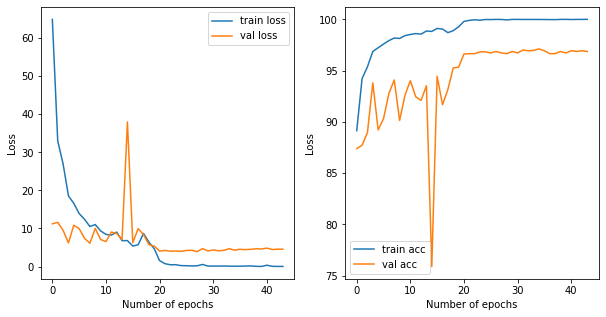

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(training_loss, label="train loss")
plt.plot(validation_loss, label="val loss")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(training_acc, label="train acc")
plt.plot(validation_acc, label="val acc")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# putting the predicted labels in a csv file
import pandas as pd
df=pd.DataFrame(columns=['id','label'])
labels = []
for i in range(len(predicted_list)):
    temp_arr = predicted_list[i].cpu().detach().numpy()
    for j in temp_arr:
        labels.append(j)
df['label']=labels
df['id']=[i for i in range(len(labels))]
df.to_csv('predictions_task2a.csv',index=False)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

with torch.no_grad():
    # iterate over test data
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
        'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

report = classification_report(y_true, y_pred,target_names=classes,output_dict=True)
# print(report)

for i in classes:
    print('Class: '+str(i)+' | Recall: '+str(round(report[i]['recall'],4)))


Class: AnnualCrop | Recall: 0.955
Class: Forest | Recall: 0.995
Class: HerbaceousVegetation | Recall: 0.9517
Class: Highway | Recall: 0.97
Class: Industrial | Recall: 0.99
Class: Pasture | Recall: 0.9575
Class: PermanentCrop | Recall: 0.932
Class: Residential | Recall: 0.9767
Class: River | Recall: 0.968
Class: SeaLake | Recall: 0.995


In [ ]:
# helper function to show images
def imshow(img):
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

True Class: PermanentCrop
Predicted Class: HerbaceousVegetation
Prediction Probability: 0.9999994


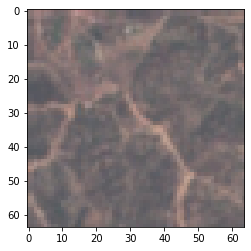

In [ ]:

index = 0

# dictionary to store information related to an image
image_prob = {}

with torch.no_grad():
    # iterate over test data
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images) # Feed Network
        _, predicted = torch.max(output.data, 1)
        sm = torch.nn.Softmax(dim=1)
        # get the softmax probabilites
        probabilities = sm(output)
        for item in range(len(predicted)):
            if(predicted[item]!=labels[item]):
                true = labels[item]
                predict = predicted[item]
                prob = torch.max(probabilities[item]).data.cpu().numpy()
                img = images[item]
                temp_tuple = (prob,img,true,predict)
                image_prob[index]=temp_tuple
                index += 1
            else:
                index +=1

# sort the dictionary in reverse order
sorted_image_prob = {k: v for k, v in sorted(image_prob.items(), key=lambda item: item[1],reverse=True)}


img_index = 1
required_keys = []
# get the top 4 probabilites
for key,value in sorted_image_prob.items():
    required_keys.append(key)
    if(img_index ==4):
        break
    img_index +=1

print('True Class: '+str((classes[(sorted_image_prob[required_keys[0]][2]).data.cpu()])))
print('Predicted Class: '+str((classes[(sorted_image_prob[required_keys[0]][3]).data.cpu()])))
print('Prediction Probability: '+str((sorted_image_prob[required_keys[0]][0])))
imshow(sorted_image_prob[required_keys[0]][1])


True Class: HerbaceousVegetation
Predicted Class: PermanentCrop
Prediction Probability: 0.9999993


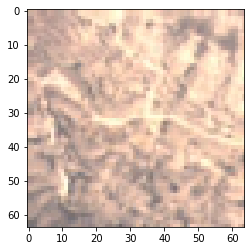

In [ ]:
print('True Class: '+str((classes[(sorted_image_prob[required_keys[1]][2]).data.cpu()])))
print('Predicted Class: '+str((classes[(sorted_image_prob[required_keys[1]][3]).data.cpu()])))
print('Prediction Probability: '+str((sorted_image_prob[required_keys[1]][0])))
imshow(sorted_image_prob[required_keys[1]][1])

True Class: HerbaceousVegetation
Predicted Class: PermanentCrop
Prediction Probability: 0.9999441


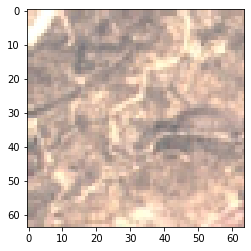

In [ ]:
print('True Class: '+str((classes[(sorted_image_prob[required_keys[2]][2]).data.cpu()])))
print('Predicted Class: '+str((classes[(sorted_image_prob[required_keys[2]][3]).data.cpu()])))
print('Prediction Probability: '+str((sorted_image_prob[required_keys[2]][0])))
imshow(sorted_image_prob[required_keys[2]][1])

True Class: PermanentCrop
Predicted Class: HerbaceousVegetation
Prediction Probability: 0.99987113


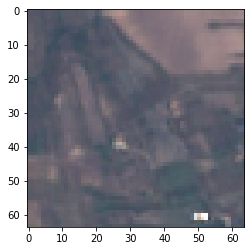

In [ ]:
print('True Class: '+str((classes[(sorted_image_prob[required_keys[3]][2]).data.cpu()])))
print('Predicted Class: '+str((classes[(sorted_image_prob[required_keys[3]][3]).data.cpu()])))
print('Prediction Probability: '+str((sorted_image_prob[required_keys[3]][0])))
imshow(sorted_image_prob[required_keys[3]][1])

# Task 2(b) : Resnet18 (Pretrained = False)

In [ ]:
untrained_model = models.resnet18(pretrained=False)
# Add an output dense layer with 10 nodes
untrained_model.fc = nn.Linear(512, 10)
untrained_model.cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# helper function to train the model
def train(untrained_model,train_loader,val_loader,loss_criteria,optimizer, epoch):
  
  train_loss = 0
  train_total = 0
  train_correct = 0

  untrained_model.train()
  # Process the images in batches
  for batch_idx, (data, target) in enumerate(train_loader):
      
    # Load the input features and labels from the dataset
    data, target = data.cuda(), target.cuda()
    
    # Reset the optimizer
    optimizer.zero_grad()
    
    # Forward pass: Pass image data from training dataset, make predictions about class image
    output = untrained_model(data)
    
    # Get the loss
    loss = loss_criteria(output, target)

    # Keep a running total
    train_loss += loss.item()

    # scores, predictions = torch.max(output.data, 1)
    train_total += target.size(0)
    train_correct += torch.sum(torch.argmax(output, dim=1) == target)
    # train_correct += int(sum(predictions == target))
  
    # Backpropagate
    loss.backward()

    # Update the neural network weights
    optimizer.step()
            
  train_acc = round((train_correct.item() / len(train_loader.dataset)) * 100, 4)
  print('Epoch [{}], train_loss: {}, train_accuracy: {}'.format(epoch, train_loss/train_total, train_acc), end='')
  print('\n')

  val_loss = 0
  val_correct = 0
  val_total = 0

  untrained_model.eval()

  # Process the images in batches
  for batch_idx, (data, target) in enumerate(val_loader):

    # Load the input features and labels from the dataset
    data, target = data.cuda(), target.cuda()

    # Forward pass: Pass image data from training dataset, make predictions about class image
    output = untrained_model(data)

    # Get the loss
    loss = loss_criteria(output, target)

    # Keep a running total
    val_loss += loss.item()


    # scores, predictions = torch.max(output.data, 1)
    val_total += target.size(0)
    val_correct += torch.sum(torch.argmax(output, dim=1) == target)
    # val_correct += int(sum(predictions == target))

  val_acc = round((val_correct.item() / len(val_loader.dataset)) * 100, 4)
  print('Epoch [{}], val_loss: {}, val_accuracy: {}'.format(epoch, val_loss/val_total, val_acc), end='')
  print('\n')
  return train_loss,train_acc,val_loss,val_acc

In [ ]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(untrained_model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# If you don't want to train the model again, don't run the below cell

In [ ]:

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
training_acc= []
validation_acc= []
val_loss_min = np.Inf
best_epoch = 0
best_model = None
patience = 15


epochs = 100
for epoch in range(1, epochs + 1):
    train_loss,train_acc,val_loss,val_acc = train(untrained_model,train_loader,val_loader,loss_criteria, optimizer, epoch)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    training_acc.append(train_acc)
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    
    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch,
        'valid_loss_min': val_loss,
        'state_dict': untrained_model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    
    # saving the model with the least validation loss
    if validation_loss[-1]<= val_loss_min:
        checkpoint_path = 'logs_resnet_task2b/resnet_ckp_2.pt'
        val_loss_min = validation_loss[-1]
        best_epoch = epoch
        best_model = untrained_model
        torch.save(model.state_dict(),checkpoint_path)
#         save_ckp(checkpoint, checkpoint_path)

    #applying the early stopping principle  
    if (epoch - best_epoch) > patience:
      print('Early stopping at epoch {}'.format(epoch))
      break
        
    scheduler.step()


Epoch [1], train_loss: 0.009296889997711076, train_accuracy: 66.4272

Epoch [1], val_loss: 0.011208380622911317, val_accuracy: 61.9658

Epoch [2], train_loss: 0.006308542370237965, train_accuracy: 77.8736

Epoch [2], val_loss: 0.00845497256500429, val_accuracy: 71.3319

Epoch [3], train_loss: 0.005170286279021045, train_accuracy: 81.854

Epoch [3], val_loss: 0.033597722225039775, val_accuracy: 36.5741

Epoch [4], train_loss: 0.004378350828241013, train_accuracy: 84.7861

Epoch [4], val_loss: 0.017841918855650812, val_accuracy: 47.8276

Epoch [5], train_loss: 0.0037052782617981966, train_accuracy: 87.0211

Epoch [5], val_loss: 0.026825340894552376, val_accuracy: 49.0741

Epoch [6], train_loss: 0.0030718955233940523, train_accuracy: 89.3412

Epoch [6], val_loss: 0.010723473742986336, val_accuracy: 70.2635

Epoch [7], train_loss: 0.002743531761095467, train_accuracy: 90.3097

Epoch [7], val_loss: 0.012776408325933833, val_accuracy: 66.3462

Epoch [8], train_loss: 0.002253968680175176, tra

In [3]:
from urllib import request
#download the model from google drive
remote_url = 'https://docs.google.com/uc?export=download&id=16IfdeQ8SWpfFV8ErSU1TC2YkH2zdPfNw'
local_file = './logs_resnet_task2b/resnet_ckp_2.pt'
request.urlretrieve(remote_url, local_file)   
# if the model is trained again, the downloaded file will be overwritten

('./logs_resnet_task2b/resnet_ckp_2.pt',
 <http.client.HTTPMessage at 0x7f691792be90>)

In [ ]:
ckp_path = "./logs_resnet_task2b/resnet_ckp_2.pt"
untrained_model.load_state_dict(torch.load(ckp_path))
# load the saved checkpoint for best model

<All keys matched successfully>

# The below cell will throw error, if model is not trained

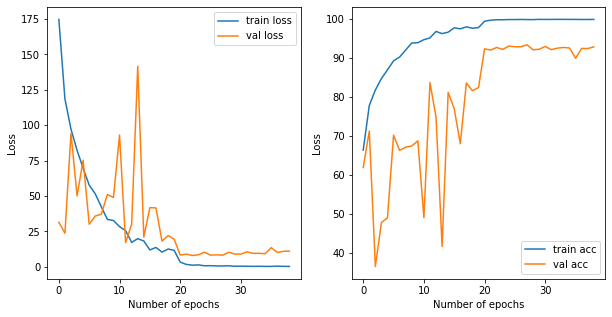

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(training_loss, label="train loss")
plt.plot(validation_loss, label="val loss")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(training_acc, label="train acc")
plt.plot(validation_acc, label="val acc")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
untrained_model.eval()
correct = 0
total = 0

# accuracy on validation set
with torch.no_grad():
    for images, labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = untrained_model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the model on the validation set: %f %%' %
      (100 * correct / total))


# accuracy on test set
correct = 0
total = 0
predicted_list = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = untrained_model(images)
        _, predicted = torch.max(output.data, 1)
        predicted_list.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the model on the test set: %f %%' %
      (100 * correct / total))

Accuracy of the model on the validation set: 92.913105 %
Accuracy of the model on the test set: 93.333333 %


In [ ]:
# putting the predicted labels in a csv file
import pandas as pd
df=pd.DataFrame(columns=['id','label'])
labels = []
for i in range(len(predicted_list)):
    temp_arr = predicted_list[i].cpu().detach().numpy()
    for j in temp_arr:
        labels.append(j)
df['label']=labels
df['id']=[i for i in range(len(labels))]
df.to_csv('predictions_task2b.csv',index=False)